# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Описание данных

Данные находятся в файле `/datasets/autos.csv`

**Признаки**
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак** 
- Price — цена (евро)

# Цель исследования

Построить модель, которая сможет определять рыночную стоимость автомобиля

# Ход исследования

1. Проведем предобработку, исследовательский анализ и подготовку данных, для создания моделей.
2. Обучите несклько моделей, и оценим их время и качесвто предсказания.
3. Опираясь на критерии заказчика, выберем лучшую модель, проверим её качество на тестовой выборке.
4. Подготовим вывод.

In [1]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [2]:
# функция для вывода первичной информации о датафреймах
def info_df(name_df):
    display(name_df.head(10))
    print(name_df.info())
    return name_df.describe()

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from catboost import Pool, CatBoostRegressor, cv, CatBoostClassifier
from lightgbm import LGBMRegressor 
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import datetime
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from time import time
#import category_encoders as ce 
from sklearn.dummy import DummyRegressor

## Подготовка данных

### Загрузка данных

In [6]:
data = pd.read_csv('/datasets/autos.csv', decimal=',')

In [7]:
info_df(data)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


В датафреме `data` видим пропуски, столбцам с датой присвоен тип `object`, метод describe показал нулевые значения в некоторых столбцах, а так же аномально большие значения, например в столбце означающем год регистрации максимальное значение 9999, явно ошибка.

### Предобработка данных

Определимся, какие признаки важны, для предсказания цены автомобиля, а какие нет.

**Важные признаки:**
- `VehicleType`
- `RegistrationYear`
- `Gearbox`
- `Power`
- `Model`
- `Kilometer`
- `FuelType`
- `Brand`
- `Repaired`

Признаки NumberOfPictures, PostalCode не несут полезной информации, их можно удалить.
DateCrawled, LastSeen, NumberOfPictures могли быть полезными для прогнозирования скорости продажи но для прогнозирования цены авто они не нужны.
DateCreated может быть полезна для анализа с учетом инфляции.

In [8]:
# посмотрим сколько в фрейме полных дубликатов, и удалим их
data.duplicated().sum()

4

In [9]:
data = data.drop_duplicates()
data.duplicated().sum()

0

In [10]:
# На основе вывода создадим новый фрейм
filtred_data = data[['VehicleType', 
                     'RegistrationYear',
                     'DateCreated',
                     'Gearbox', 
                     'Power',
                     'Model',
                     'Kilometer',
                     'FuelType',
                     'Brand',
                     'Repaired',
                     'Price']]
filtred_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       316875 non-null  object
 1   RegistrationYear  354365 non-null  int64 
 2   DateCreated       354365 non-null  object
 3   Gearbox           334532 non-null  object
 4   Power             354365 non-null  int64 
 5   Model             334660 non-null  object
 6   Kilometer         354365 non-null  int64 
 7   FuelType          321470 non-null  object
 8   Brand             354365 non-null  object
 9   Repaired          283211 non-null  object
 10  Price             354365 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 32.4+ MB


In [11]:
# создадим функцию для создания гистограмм распределения
def ht_func_col(name_df, list_colmun):
    fig, axes = plt.subplots(1, 3, figsize=(20, 7))

    for i, col in enumerate(list_colmun):
        sns.histplot(x=name_df[col], ax=axes[i%3])
        axes[i%3].set_title(f'Гистограмма распределения по {col}')

    plt.tight_layout()
    plt.show()

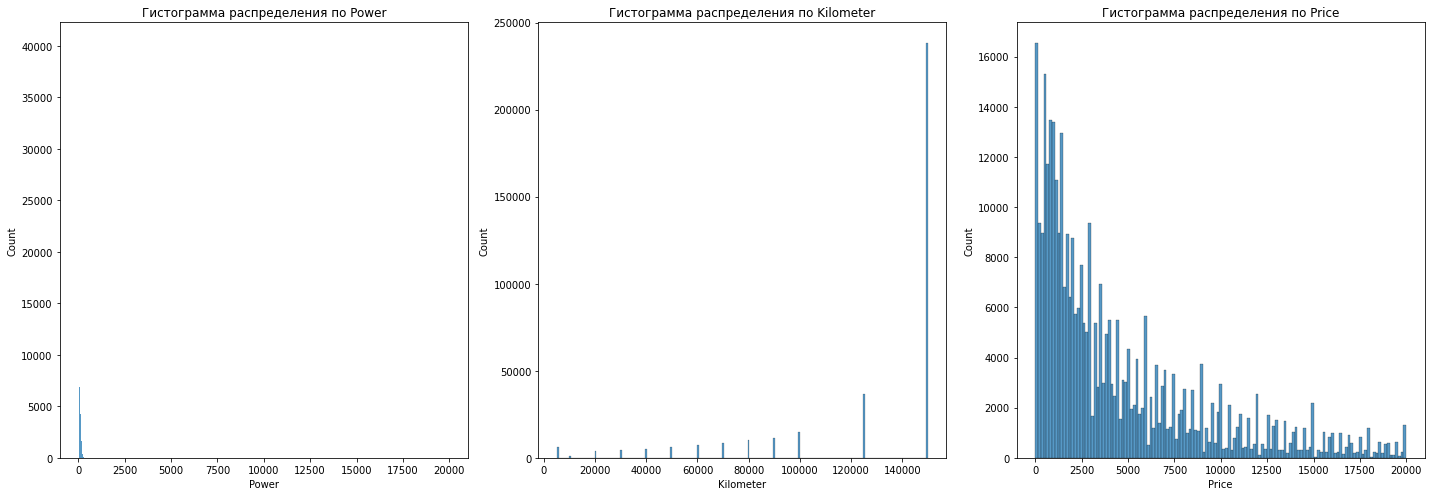

In [12]:
# построим гистограммы до удаления дубликатов
ht_func_col(filtred_data, ['Power', 'Kilometer', 'Price'])

In [13]:
# посмотрим сколько имеется полных дубликатов
filtred_data.duplicated().sum()

13368

In [14]:
# удалим полные дубликаты
filtred_data = filtred_data.drop_duplicates()
filtred_data.duplicated().sum()

0

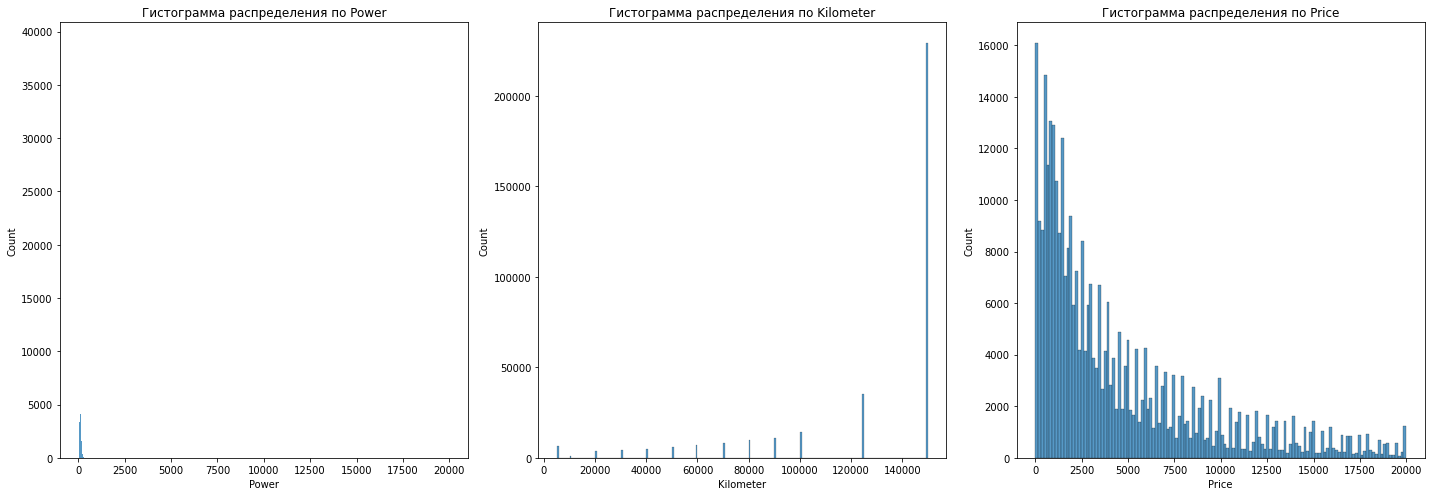

In [15]:
# оценим как изменилось распределение
ht_func_col(filtred_data, ['Power', 'Kilometer', 'Price'])

Можем заметить что распределение признаков практически не поменялось, следовательно, удаление дубликатов было хорошим решением

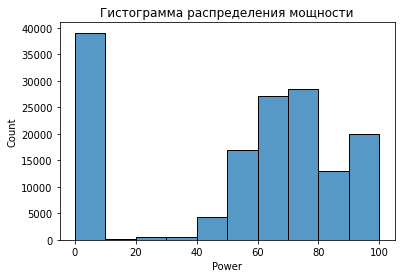

In [16]:
# стоит взгялнуть на гистограмму распределдения мощьности автомобиля поподробней
sns.histplot(data=filtred_data, x='Power', bins=10, binrange=(0, 100))
plt.title('Гистограмма распределения мощности')
plt.show()

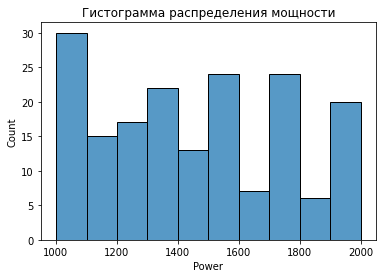

In [17]:
sns.histplot(data=filtred_data, x='Power', bins=10, binrange=(1001, 2000))
plt.title('Гистограмма распределения мощности')
plt.show()

Судя по построенным гистограммам можем исключить те автомобили, в которых мощьность менее 40 и более 1000 лошадиных сил.

In [18]:
filtred_data = filtred_data.query('39 < Power < 1001')
filtred_data.describe()

,RegistrationYear,Power,Kilometer,Price
count,300418.000000,300418.000000,300418.000000,300418.000000
mean,2003.526357,120.683218,128725.459194,4699.046748
std,34.083302,54.794760,36607.021132,4594.002555
min,1000.000000,40.000000,5000.000000,0.000000
25%,1999.000000,75.000000,125000.000000,1226.250000
50%,2003.000000,110.000000,150000.000000,2999.000000
75%,2008.000000,150.000000,150000.000000,6850.000000
max,9999.000000,1000.000000,150000.000000,20000.000000


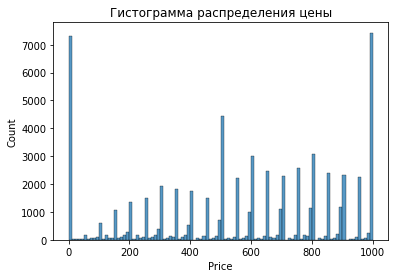

In [19]:
# посмотрим на гистограмму распределеия цены автомобиля подробнее
sns.histplot(data=filtred_data, x='Price', bins=100, binrange=(0, 1000))
plt.title('Гистограмма распределения цены')
plt.show()

In [20]:
# считаю можно удалить все знаечния с ценой менее 200 евро
filtred_data = filtred_data.query('199 < Price')
filtred_data.describe()

,RegistrationYear,Power,Kilometer,Price
count,289965.000000,289965.000000,289965.000000,289965.000000
mean,2003.591013,121.201507,128567.809908,4867.020106
std,28.455964,54.460657,36514.652583,4588.531997
min,1000.000000,40.000000,5000.000000,200.000000
25%,1999.000000,79.000000,125000.000000,1390.000000
50%,2003.000000,112.000000,150000.000000,3200.000000
75%,2008.000000,150.000000,150000.000000,6990.000000
max,9999.000000,1000.000000,150000.000000,20000.000000


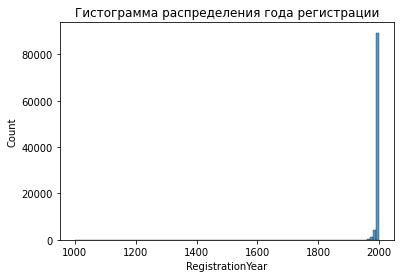

In [21]:
# разберемся с годом регистрации
sns.histplot(data=filtred_data, x='RegistrationYear', bins=100, binrange=(1000, 2000))
plt.title('Гистограмма распределения года регистрации')
plt.show()

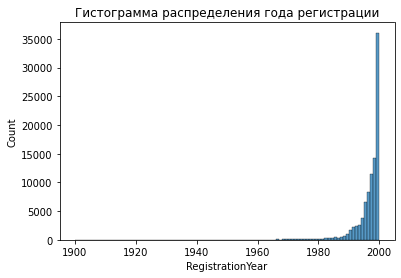

In [22]:
sns.histplot(data=filtred_data, x='RegistrationYear', bins=100, binrange=(1900, 2000))
plt.title('Гистограмма распределения года регистрации')
plt.show()

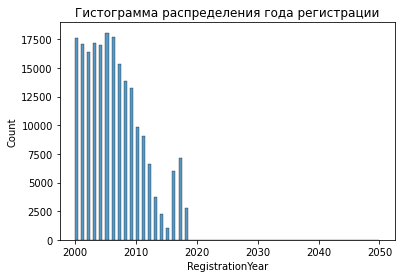

In [23]:
sns.histplot(data=filtred_data, x='RegistrationYear', bins=100, binrange=(2000, 2050))
plt.title('Гистограмма распределения года регистрации')
plt.show()

In [24]:
# изменим тип столбеца с датой выгрузки на datetime 
new_data = data.copy()
new_data['DateCrawled'] = pd.to_datetime(
    new_data['DateCrawled'], format='%Y-%m-%dT%H:%M:%S')
# создадим новый столбец в котором будут отмечены только года
new_data['Year'] = pd.DatetimeIndex(new_data['DateCrawled']).year

In [25]:
filtred_data['DateCreated'] = pd.to_datetime(
    filtred_data['DateCreated'], format='%Y-%m-%dT%H:%M:%S')
# создадим новый столбец в котором будут отмечены только года
filtred_data['Year'] = pd.DatetimeIndex(filtred_data['DateCreated']).year
filtred_data['Month'] = pd.DatetimeIndex(filtred_data['DateCreated']).month

In [26]:
# Создадим новый признак AgeYear возраст автомобиля
filtred_data['AgeYear'] = filtred_data['Year'] - filtred_data['RegistrationYear']
filtred_data['AgeMonth'] = filtred_data['AgeYear'] * 12 + filtred_data['Month']
filtred_data.head()

,VehicleType,RegistrationYear,DateCreated,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,Price,Year,Month,AgeYear,AgeMonth
1,coupe,2011,2016-03-24,manual,190,NaN,125000,gasoline,audi,yes,18300,2016,3,5,63
2,suv,2004,2016-03-14,auto,163,grand,125000,gasoline,jeep,NaN,9800,2016,3,12,147
3,small,2001,2016-03-17,manual,75,golf,150000,petrol,volkswagen,no,1500,2016,3,15,183
4,small,2008,2016-03-31,manual,69,fabia,90000,gasoline,skoda,no,3600,2016,3,8,99
5,sedan,1995,2016-04-04,manual,102,3er,150000,petrol,bmw,yes,650,2016,4,21,256


In [27]:
max(filtred_data['AgeMonth']), min(filtred_data['AgeMonth'])

(12195, -95793)

In [28]:
# найдем максимальное значение столбца с годами, по которому ограничим даты регистрации автомобиля
max_year_unloading = max(new_data['Year'])
max_year_unloading

2016

In [29]:
# уберем автомобили страше 1960 и младше 2016 годов
filtred_data = filtred_data.query('1959 < RegistrationYear < 2017')
filtred_data.describe()

,RegistrationYear,Power,Kilometer,Price,Year,Month,AgeYear,AgeMonth
count,279923.000000,279923.000000,279923.000000,279923.000000,279923.000000,279923.000000,279923.000000,279923.000000
mean,2002.945757,121.590798,128429.675304,4910.100603,2015.999929,3.161912,13.054172,159.811977
std,6.320686,54.442459,36554.243303,4612.505267,0.008452,0.377907,6.320705,75.849260
min,1960.000000,40.000000,5000.000000,200.000000,2015.000000,1.000000,0.000000,1.000000
25%,1999.000000,80.000000,125000.000000,1399.000000,2016.000000,3.000000,9.000000,111.000000
50%,2003.000000,114.000000,150000.000000,3200.000000,2016.000000,3.000000,13.000000,159.000000
75%,2007.000000,150.000000,150000.000000,6999.000000,2016.000000,3.000000,17.000000,207.000000
max,2016.000000,1000.000000,150000.000000,20000.000000,2016.000000,12.000000,56.000000,676.000000


In [30]:
filtred_data = filtred_data.drop(columns=['RegistrationYear', 'DateCreated', 'Year', 'AgeYear', 'Month'])

In [31]:
max(filtred_data['AgeMonth']), min(filtred_data['AgeMonth'])

(676, 1)

In [32]:
filtred_data.head()

,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,Price,AgeMonth
1,coupe,manual,190,NaN,125000,gasoline,audi,yes,18300,63
2,suv,auto,163,grand,125000,gasoline,jeep,NaN,9800,147
3,small,manual,75,golf,150000,petrol,volkswagen,no,1500,183
4,small,manual,69,fabia,90000,gasoline,skoda,no,3600,99
5,sedan,manual,102,3er,150000,petrol,bmw,yes,650,256


In [33]:
filtred_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 279923 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   VehicleType  269781 non-null  object
 1   Gearbox      275030 non-null  object
 2   Power        279923 non-null  int64 
 3   Model        269550 non-null  object
 4   Kilometer    279923 non-null  int64 
 5   FuelType     265428 non-null  object
 6   Brand        279923 non-null  object
 7   Repaired     239542 non-null  object
 8   Price        279923 non-null  int64 
 9   AgeMonth     279923 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 23.5+ MB


На данный момент фрейм данных сократился практически на треть, но все еще имеется большое количество пропусков, попробуем их заполнить.

In [34]:
# Имеются пропуски в Model к сожалению их нельзя восстановит по Brand придется удалить
filtred_data = filtred_data.loc[~filtred_data['Model'].isna()]

In [35]:
# Тип кузова может быть разный даже у одной марки и модели автомобиля, так что заполним пропуски заглушкой unknow
filtred_data['VehicleType'] = filtred_data['VehicleType'].fillna('unknown')

In [36]:
# Пропуски в Repaired заменим на no, скорее всего если автомобиль не чинился, данный пункт не отмечали
filtred_data['Repaired'].fillna('no', inplace=True)

In [37]:

# Разделим датафрейм filtred_data на тренировочный и тестовый
train, test = train_test_split(
    filtred_data,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE
    )

In [38]:
# Колличество пропусков в Gearbox тоже велико. Заменим на наиболее встречающийся тип коробки в модели.
train['Gearbox'] = train['Gearbox'].fillna(train
                                         .groupby('Model')['Gearbox']
                                         .transform(lambda x: x.value_counts().idxmax())
                                        )

test['Gearbox'] = test['Gearbox'].fillna(test
                                         .groupby('Model')['Gearbox']
                                         .transform(lambda x: x.value_counts().idxmax())
                                        )

In [39]:
# Пропуски в FuelType заменим на среднее по моделям
train['FuelType'] = train['FuelType'].fillna(train
                                           .groupby('Model')['FuelType']
                                           .transform(lambda x: x.value_counts().idxmax())
                                          )

test['FuelType'] = test['FuelType'].fillna(test
                                           .groupby('Model')['FuelType']
                                           .transform(lambda x: x.value_counts().idxmax())
                                          )

In [40]:
train.isna().sum()

VehicleType    0
Gearbox        0
Power          0
Model          0
Kilometer      0
FuelType       0
Brand          0
Repaired       0
Price          0
AgeMonth       0
dtype: int64

In [41]:
test.isna().sum()

VehicleType    0
Gearbox        0
Power          0
Model          0
Kilometer      0
FuelType       0
Brand          0
Repaired       0
Price          0
AgeMonth       0
dtype: int64

In [42]:
train.duplicated().sum()

17528

In [43]:
test.duplicated().sum()

2377

In [44]:
# удалим полные дубликаты
train = train.drop_duplicates()
print(train.duplicated().sum())

test = test.drop_duplicates()
print(test.duplicated().sum())

0
0


In [45]:
train = train.reset_index(drop=True)

test = test.reset_index(drop=True)

In [46]:
display(
    info_df(train),
    info_df(test))

,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,Price,AgeMonth
0,wagon,manual,109,focus,150000,gasoline,ford,no,6990,76
1,small,manual,68,other,100000,petrol,suzuki,no,3700,87
2,sedan,manual,60,astra,150000,petrol,opel,no,1049,243
3,wagon,manual,136,4_reihe,150000,petrol,peugeot,no,3200,159
4,sedan,auto,122,c_klasse,150000,petrol,mercedes_benz,no,1250,267
5,wagon,manual,150,astra,150000,gasoline,opel,no,3100,111
6,small,manual,88,micra,125000,petrol,nissan,no,1800,159
7,convertible,auto,90,tigra,100000,petrol,opel,no,4700,123
8,sedan,manual,113,3er,150000,petrol,bmw,yes,999,327
9,other,manual,78,other,150000,gasoline,volkswagen,no,3350,291


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184634 entries, 0 to 184633
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   VehicleType  184634 non-null  object
 1   Gearbox      184634 non-null  object
 2   Power        184634 non-null  int64 
 3   Model        184634 non-null  object
 4   Kilometer    184634 non-null  int64 
 5   FuelType     184634 non-null  object
 6   Brand        184634 non-null  object
 7   Repaired     184634 non-null  object
 8   Price        184634 non-null  int64 
 9   AgeMonth     184634 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 14.1+ MB
None


,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,Price,AgeMonth
0,wagon,manual,100,focus,150000,petrol,ford,no,1750,195
1,convertible,manual,109,2_reihe,150000,gasoline,peugeot,no,6200,111
2,sedan,auto,143,1er,125000,petrol,bmw,no,9150,99
3,sedan,manual,105,golf,125000,gasoline,volkswagen,no,10900,75
4,bus,manual,131,sharan,150000,gasoline,volkswagen,no,5000,147
5,small,manual,101,polo,150000,gasoline,volkswagen,no,2500,159
6,sedan,manual,125,a4,150000,petrol,audi,no,550,255
7,wagon,manual,140,passat,150000,gasoline,volkswagen,no,8750,111
8,small,manual,50,lupo,150000,petrol,volkswagen,no,800,207
9,sedan,manual,231,5er,150000,petrol,bmw,no,5300,183


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65011 entries, 0 to 65010
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   VehicleType  65011 non-null  object
 1   Gearbox      65011 non-null  object
 2   Power        65011 non-null  int64 
 3   Model        65011 non-null  object
 4   Kilometer    65011 non-null  int64 
 5   FuelType     65011 non-null  object
 6   Brand        65011 non-null  object
 7   Repaired     65011 non-null  object
 8   Price        65011 non-null  int64 
 9   AgeMonth     65011 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 5.0+ MB
None


,Power,Kilometer,Price,AgeMonth
count,184634.000000,184634.000000,184634.000000,184634.000000
mean,122.717381,127316.068546,5078.953773,157.469621
std,54.382023,37065.443809,4669.801601,75.267220
min,40.000000,5000.000000,200.000000,1.000000
25%,82.000000,125000.000000,1499.000000,111.000000
50%,115.000000,150000.000000,3490.000000,159.000000
75%,150.000000,150000.000000,7350.000000,207.000000
max,1000.000000,150000.000000,20000.000000,676.000000


,Power,Kilometer,Price,AgeMonth
count,65011.000000,65011.000000,65011.000000,65011.000000
mean,121.861777,128182.307609,4971.054099,158.957269
std,53.719449,36711.164974,4625.922677,74.543736
min,40.000000,5000.000000,200.000000,2.000000
25%,80.000000,125000.000000,1444.000000,111.000000
50%,115.000000,150000.000000,3300.000000,159.000000
75%,150.000000,150000.000000,7000.000000,207.000000
max,953.000000,150000.000000,20000.000000,676.000000


In [47]:
# Посмотрим на уникальные значения в столбах, есть ли там опечатки
def unique_df(df):
    list_columns = df.columns.to_list()
    for i in range(len(list_columns)):
        if df[list_columns[i]].dtype == object:
            print(f'{list_columns[i]}: {df[list_columns[i]].unique()}')

In [48]:
unique_df(filtred_data)

VehicleType: ['suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'unknown' 'coupe'
 'other']
Gearbox: ['auto' 'manual' nan]
Model: ['grand' 'golf' 'fabia' '3er' '2_reihe' 'c_max' '3_reihe' 'passat'
 'navara' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er' 'arosa' 'other'
 'civic' 'transporter' 'punto' 'e_klasse' 'clio' 'kadett' 'one' 'fortwo'
 '1er' 'b_klasse' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito'
 'sprinter' '156' 'escort' 'forester' 'xc_reihe' 'scenic' 'ka' 'a1'
 'focus' 'a4' 'tt' 'astra' 'a6' 'jazz' 'omega' 'slk' '7er' 'combo' 'corsa'
 '80' '147' 'z_reihe' 'sorento' 'ibiza' 'mustang' 'eos' 'touran' 'getz'
 'insignia' 'almera' 'megane' 'a3' 'lupo' 'r19' 'caddy' 'mondeo' 'cordoba'
 'colt' 'impreza' 'vectra' 'berlingo' 'tiguan' '6_reihe' 'c4' 'panda' 'up'
 'i_reihe' 'ceed' 'kangoo' '5_reihe' 'yeti' 'octavia' 'zafira' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'rio' 'touareg' 'logan'
 'spider' 'cuore' 's_max' 'a2' 'galaxy' 'c3' 'viano' 's_klasse' '1_reihe'
 'sharan' 'av

In [49]:
target_train = train['Price']
features_train = train.drop('Price', axis=1)

target_test = test['Price']
features_test = test.drop('Price', axis=1)

**Выводы**

1. Загрузили данные из датсета `/datasets/autos.csv`
2. Провели предобработку данных, отделив важные признаки от несущественных, для определения цены автомобиля
**Важные признаки:**
- `VehicleType`
- `AgeMonth`
- `Gearbox`
- `Power`
- `Model`
- `Kilometer`
- `FuelType`
- `Brand`
- `Repaired`
3. На основе гистограмм распределения удалил незначимые значения признаков, по разным порогам.
4. Заполнили столбец `Gearbox` наиболее встречающийся тип коробки в модели.
5. Пропуски в `FuelType` заменили на среднее по моделям.
6. Пропуски в `Repaired` заменим на `no`, скорее всего если автомобиль не чинился, данный пункт не отмечали.
7. Тип кузова может быть разный даже у одной марки и модели автомобиля, так что заполним пропуски в столбце `VehicleType` заглушкой `unknow`.
8. Удалили полные дубликаты.
9. Синтаксических ошибок в фреймах не обнаружено.

## Обучение моделей

In [50]:
# создадим списки для энкондеров
# создадим списки для энкондеров
cat_columns = [
    'VehicleType',
    'FuelType',
    'Brand',
    'Model',
    'Gearbox',
    'Repaired'
]
num_columns = [
    'Power',
    'Kilometer',
    'AgeMonth'
]

In [51]:
# Добавляем OHE-кодирование в пайплайн

ohe_pipe = Pipeline([('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))])

In [52]:
# Добавляем Ordinal-кодирование в пайплайн
ord_pipe = Pipeline(
    [('ord', OrdinalEncoder(
    handle_unknown='use_encoded_value', 
    unknown_value=np.nan))
                    ]
                   )

In [53]:
# создадим препроессор, по обработке данных для LR
data_preprocessor_LR = ColumnTransformer(
    [
        ('ohe', ohe_pipe, cat_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [54]:
# создадим препроессор, по обработке данных для DTR
data_preprocessor_DTR = ColumnTransformer(
    [
        ('ord', ord_pipe, cat_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [55]:
# создадим финальный пайплайн LR
pipe_final_LR = Pipeline([
    ('preprocessor', data_preprocessor_LR),
    ('models', LinearRegression())
])

In [56]:
# создадим финальный пайплайн DTR
pipe_final_DTR = Pipeline([
    ('preprocessor', data_preprocessor_DTR),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

In [57]:
# словарь для модели DecisionTreeRegressor()
param_grid_DTR = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'models__max_features': range(2, 10),
        'preprocessor__num': [StandardScaler(), RobustScaler(), 'passthrough']  
    }
]

In [58]:
# словарь для модели LinearRegression()
param_grid_LR = [
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), RobustScaler(), 'passthrough']  
    }
]

Подготовим три типа признаков для кроссвалидации:

- Неизмененные. Название original_features.
- Закодированные методом OHE. Название ohe_features.
- Закодированные методом ORD. Название ordinal_features.

### Линейная регрессия

In [59]:
grided_search_LR = GridSearchCV(
    pipe_final_LR, 
    param_grid_LR, 
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

In [60]:
grided_search_LR.fit(features_train, target_train)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['VehicleType',
                                                                          'FuelType',
                                                                          'Brand',
                                                                          'Model',
                                                                          'Gearbox',
                                                                          'Repaired']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['Power',
                                                                          'Kilometer',
                                                                          'AgeMonth'])])),
                                       ('models', LinearRegression())]),
             n_jobs=-1,
             param_grid=[{'models': [LinearRegression()],
                          'preprocessor__num': [StandardScaler(),
                                                RobustScaler(),
                                                'passthrough']}],
             scoring='neg_mean_squared_error')

In [61]:
print('Лучшая модель и её параметры:\n\n', grided_search_LR.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', (grided_search_LR.best_score_ * -1) ** 0.5)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['VehicleType', 'FuelType',
                                                   'Brand', 'Model', 'Gearbox',
                                                   'Repaired']),
                                                 ('num', StandardScaler(),
                                                  ['Power', 'Kilometer',
                                                   'AgeMonth'])]))

In [62]:
best_model_LR = grided_search_LR.best_estimator_

In [63]:
start = time()

best_model_LR.fit(features_train, target_train)

end = time()

model_time_train_LR = (end-start)
print(f'Время обучения лучшей модели линейной ргерессии: {model_time_train_LR:.3f} секунд')

Время обучения лучшей модели линейной ргерессии: 15.681 секунд


In [64]:
start = time()

best_model_LR.predict(features_train)

end = time()

model_time_predict_LR = (end-start)
print(f'Время предсказания лучшей модели линейной ргерессии: {model_time_predict_LR:.3f} секунд')

Время предсказания лучшей модели линейной ргерессии: 1.104 секунд


In [65]:
RMSE_best_model_LR = (grided_search_LR.best_score_ * -1) ** 0.5

**RMSE лучшей модели линейной рергрессии составило 2566.68**

### Регрессия DecisionTreeRegressor

In [66]:
randomized_search_DTR = RandomizedSearchCV(
    pipe_final_DTR, 
    param_grid_DTR, 
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [67]:
randomized_search_DTR.fit(features_train, target_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ord',
                                                                               Pipeline(steps=[('ord',
                                                                                                OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                               unknown_value=nan))]),
                                                                               ['VehicleType',
                                                                                'FuelType',
                                                                                'Brand',
                                                                                'Model',
                                                                                'Gearbox',
                                                                                'Repaired']),
                                                                              ('num',
                                                                               StandardScaler(),
                                                                               ['Power',
                                                                                'Kilometer',
                                                                                'AgeMonth'])])),
                                             ('models',
                                              DecisionTreeRegressor(random_state=42))]),
                   n_jobs=-1,
                   param_distributions=[{'models': [DecisionTreeRegressor(random_state=42)],
                                         'models__max_depth': range(2, 10),
                                         'models__max_features': range(2, 10),
                                         'preprocessor__num': [StandardScaler(),
                                                               RobustScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='neg_mean_squared_error')

In [68]:
print('Лучшая модель и её параметры:\n\n', randomized_search_DTR.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', (randomized_search_DTR.best_score_ * -1) ** 0.5)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan))]),
                                                  ['VehicleType', 'FuelType',
                                                   'Brand', 'Model', 'Gearbox',
                                                   'Repaired']),
                                                 ('num', StandardScaler(),
                                                  ['Power', 'Kilometer',
                                                   'AgeMonth'])])),
                ('models',
                 DecisionTreeRegressor(max_depth=9, max

In [69]:
best_model_DTR = randomized_search_DTR.best_estimator_

In [70]:
start = time()

best_model_DTR.fit(features_train, target_train)

end = time()

model_time_train_DTR = (end-start)
print(f'Время обучения лучшей модели линейной ргерессии: {model_time_train_DTR:.3f} секунд')

Время обучения лучшей модели линейной ргерессии: 0.425 секунд


In [71]:
start = time()

best_model_DTR.predict(features_train)

end = time()

model_time_predict_DTR = (end-start)
print(f'Время предсказания лучшей модели линейной ргерессии: {model_time_predict_DTR:.3f} секунд')

Время предсказания лучшей модели линейной ргерессии: 0.244 секунд


In [72]:
RMSE_best_model_DTR = (randomized_search_DTR.best_score_ * -1) ** 0.5

**Оценка RMSE случайного дерева решений составила 2077.42**

### Регрессия CatBoostRegressor

In [73]:
model_CBR = CatBoostRegressor(random_state=RANDOM_STATE, cat_features=cat_columns)

# словарь для модели CatBoostRegressor()
params_CBR = [
    {
        'loss_function': ['RMSE'],
        'iterations': [1000],
        'learning_rate': [0.1, 0.3, 0.5],
        'verbose': [False],
    }
]

In [74]:
grided_search_CBR = GridSearchCV(
    model_CBR, 
    params_CBR, 
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

In [75]:
grided_search_CBR.fit(features_train, target_train)

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f59f80c0d60>,
             n_jobs=-1,
             param_grid=[{'iterations': [1000],
                          'learning_rate': [0.1, 0.3, 0.5],
                          'loss_function': ['RMSE'], 'verbose': [False]}],
             scoring='neg_mean_squared_error')

In [76]:
print('Лучшая модель и её параметры:\n\n', grided_search_CBR.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', (grided_search_CBR.best_score_ * -1) ** 0.5)

Лучшая модель и её параметры:

Метрика лучшей модели на кросс-валидации: 1581.1388421411586


In [77]:
best_model_CBR = grided_search_CBR.best_estimator_

In [78]:
start = time()

best_model_CBR.fit(features_train, target_train)

end = time()

model_time_train_CBR = (end-start)
print(f'Время обучения лучшей модели линейной ргерессии: {model_time_train_CBR:.3f} секунд')

Время обучения лучшей модели линейной ргерессии: 127.821 секунд


In [79]:
start = time()

x = best_model_CBR.predict(features_train)

end = time()

model_time_predict_CBR = (end-start)
print(f'Время предсказания лучшей модели линейной ргерессии: {model_time_predict_CBR:.3f} секунд')

Время предсказания лучшей модели линейной ргерессии: 1.759 секунд


In [80]:
RMSE_best_model_CBR = (grided_search_CBR.best_score_ * -1) ** 0.5

Оценка RMSE Catboost составила 1581.14

### Регрессия LGBM

In [81]:
model_LGBM = LGBMRegressor(random_state=RANDOM_STATE, categorical_feature=cat_columns)

# словарь для модели LGBMRegressor()
params_LGBM = [
    {       
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.1, 0.3, 0.5]
    }
]

In [82]:
features_train_LGBM = features_train.copy()

In [83]:
for c in features_train_LGBM.columns:
    col_type = features_train_LGBM[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        features_train_LGBM[c] = features_train_LGBM[c].astype('category')

In [84]:
grided_search_LGBM = GridSearchCV(
    model_LGBM, 
    params_LGBM, 
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

In [85]:
grided_search_LGBM.fit(features_train_LGBM, target_train)

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param di

GridSearchCV(cv=5,
             estimator=LGBMRegressor(categorical_feature=['VehicleType',
                                                          'FuelType', 'Brand',
                                                          'Model', 'Gearbox',
                                                          'Repaired'],
                                     random_state=42),
             n_jobs=-1,
             param_grid=[{'learning_rate': [0.1, 0.3, 0.5],
                          'n_estimators': [50, 100, 200]}],
             scoring='neg_mean_squared_error')

In [86]:
print('Лучшая модель и её параметры:\n\n', grided_search_LGBM.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', (grided_search_LGBM.best_score_ * -1) ** 0.5)

Лучшая модель и её параметры:

 LGBMRegressor(categorical_feature=['VehicleType', 'FuelType', 'Brand', 'Model',
                                   'Gearbox', 'Repaired'],
              learning_rate=0.3, n_estimators=200, random_state=42)
Метрика лучшей модели на кросс-валидации: 1571.9773941289375


In [87]:
best_model_LGBM = grided_search_LGBM.best_estimator_

In [88]:
start = time()

best_model_LGBM.fit(features_train_LGBM, target_train)

end = time()

model_time_train_LGBM = (end-start)
print(f'Время обучения лучшей модели линейной ргерессии: {model_time_train_LGBM:.3f} секунд')

Время обучения лучшей модели линейной ргерессии: 7.892 секунд


In [89]:
start = time()

x = best_model_LGBM.predict(features_train_LGBM)

end = time()

model_time_predict_LGBM = (end-start)
print(f'Время предсказания лучшей модели линейной ргерессии: {model_time_predict_LGBM:.3f} секунд')

Время предсказания лучшей модели линейной ргерессии: 2.197 секунд


In [90]:
RMSE_best_model_LGBM = (grided_search_LGBM.best_score_ * -1) ** 0.5

Оценка RMSE LGBMRegressor составила 1571.03

**Вывод**

Были обычучены модель линейной ргересси, дерево решений, CatBoost и LightGBM, с различными гиперпарамтерами, и OHE,ORD и внутренними механизмами кодирования.

Получено время обучения, время предсказания и оценка RMSE моделей на тренировочных данных.

## Анализ моделей

In [91]:
df = [[model_time_train_LR, model_time_predict_LR, RMSE_best_model_LR],
        [model_time_train_DTR, model_time_predict_DTR, RMSE_best_model_DTR],
        [model_time_train_CBR, model_time_predict_CBR, RMSE_best_model_CBR],
        [model_time_train_LGBM, model_time_predict_LGBM, RMSE_best_model_LGBM]]
model = ['Linear Regression',
         'DecisionTreeRegressor',
         'CatBoostRegressor',
         'LGBMRegressor']

In [92]:
pd.DataFrame(data=df, index=model, columns=['fit_time в секундах', 'predict_time в секундах', 'RMSE'])

,fit_time в секундах,predict_time в секундах,RMSE
Linear Regression,15.681286,1.103778,2566.682144
DecisionTreeRegressor,0.425420,0.244202,2077.416745
CatBoostRegressor,127.820511,1.758558,1581.138842
LGBMRegressor,7.892413,2.197156,1571.977394


In [93]:
features_test_LGBM = features_test.copy()

In [94]:
for c in features_test_LGBM.columns:
    col_type = features_test_LGBM[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        features_test_LGBM[c] = features_test_LGBM[c].astype('category')

In [95]:
# оценим метрику RMSE на тестовой выборке лучшей моделью
pred_best_model_LGBM = best_model_LGBM.predict(features_test_LGBM)

RMSE_best_model = mean_squared_error(target_test, pred_best_model_LGBM) ** 0.5
print(f'Метрика RMSE лучшей модели на тестовых данных составляет: {RMSE_best_model:.2f}')

Метрика RMSE лучшей модели на тестовых данных составляет: 1532.86


In [96]:
# Проверим качество лучшей модели сравнив ее метрику с предсказанием коснтантной модели
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train, target_train)
DummyRegressor()
dummy_pred = dummy_regr.predict(features_test)
dummy_RMSE = mean_squared_error(target_test, dummy_pred) ** 0.5
print(f'Метрика RMSE константной модели составлет: {dummy_RMSE}')

Метрика RMSE константной модели составлет: 4627.145317280954


Метрика RMSE `DummyRegressor` в разы превышет метрику `LGBMRegressor`, следовательно использование `LGBMRegressor` оправдано.

**Вывод**

Лучшие значения RMSE показали `CatBoost` и `LightGBM` отличия незнаичтельные. Однако у `LightGBM` время обучения в разы меньше чем у `CatBoost`, 9 секунд против 130 секунд. Время предсказания у `LightGBM` незначительно хуже.

Оценив все показатали `LightGBM` считаю наилучшей, так как время обучения значительно лучше, оценка RMSE так же лучше, и лишь по времени предсказания `LightGBM` немного проигрывает

Метрика RMSE лучшей модели на тестовых данных составляет: 1534.60

## Общий вывод

**Шаг 1**

1. Загрузили данные из датсета `/datasets/autos.csv`
2. Провели предобработку данных, отделив важные признаки от несущественных, для определения цены автомобиля
**Важные признаки:**
- `VehicleType`
- `RegistrationYear`
- `Gearbox`
- `Power`
- `Model`
- `Kilometer`
- `FuelType`
- `Brand`
- `Repaired`
3. На основе гистограмм распределения удалил незначимые значения признаков, по разным порогам.
4. Заполнили столбец `Gearbox` наиболее встречающийся тип коробки в модели.
5. Пропуски в `FuelType` заменили на среднее по моделям.
6. Пропуски в `Repaired` заменим на `no`, скорее всего если автомобиль не чинился, данный пункт не отмечали.
7. Тип кузова может быть разный даже у одной марки и модели автомобиля, так что заполним пропуски в столбце `VehicleType` заглушкой `unknow`.
8. Удалили полные дубликаты.
9. Синтаксических ошибок в фреймах не обнаружено.

**Шаг 2**

Были обычучены модель линейной ргересси, дерево решений, CatBoost и LightGBM, с различными гиперпарамтерами, и OHE,ORD и внутренними механизмами кодирования.

Получено время обучения, время предсказания и оценка RMSE моделей на тренировочных данных.

**Шаг 3**

Лучшие значения RMSE показали `CatBoost` и `LightGBM` отличия незнаичтельные. Однако у `LightGBM` время обучения в разы меньше чем у `CatBoost`, 9 секунд против 130 секунд. Время предсказания у `LightGBM` незначительно хуже.

Оценив все показатали `LightGBM` считаю наилучшей, так как время обучения значительно лучше, оценка RMSE так же лучше, и лишь по времени предсказания `LightGBM` немного проигрывает

**Метрика RMSE лучшей модели на тестовых данных составляет: 1534.60**